# part 1, generate data sample 

Skip  down to part 2 when running this notebook where the csv is read in this part creates the csv from the files on the website for part where the generated csv is loaded in, these files are from the https://sites.google.com/eng.ucsd.edu/fitrec-project/home 

## get full data with 960,000 entries

In [1]:
import dask.bag as db #parallel loading
import ast
import pandas as pd
import json
def process_row(row):
    try:
        # Convert string representation of a dictionary to an actual dictionary
        return ast.literal_eval(row)
    except ValueError as e:
        # Handle potential errors in conversion
        print(f"Error processing row: {e}")
        return None

# Read the JSON file with Dask
b = db.read_text("endomondoMeta.json").map(process_row) #this file is from the website 

# Filter out None values in case of any errors
b = b.filter(lambda x: x is not None)

# Convert to Dask DataFrame
df = b.to_dataframe()

# Optional: Convert to Pandas DataFrame if the data fits into memory
data1 = df.compute()



In [2]:
data1.shape

(962190, 13)

## Get meta data, sample 250,000 rows

In [3]:
import pandas as pd
import json
from concurrent.futures import ProcessPoolExecutor

# Function to process a chunk of lines
def process_lines(chunk):
    processed_chunk = []
    for line in chunk:
        try:
            processed_chunk.append(json.loads(line))
        except json.JSONDecodeError:
            continue
    return processed_chunk

# Load the data and prepare it
with open('endomondoHR.json', 'r') as f: #file from website
    raw_content = f.read()
corrected_content = raw_content.replace("'", '"')
lines = corrected_content.splitlines()

# Truncate to the first 450,000 lines if the file has more lines
lines = lines[:600000]

# Determine the optimal chunk size
chunk_size = len(lines) // 32  # or another value based on experimentation

# Split lines into chunks
chunks = [lines[i:i + chunk_size] for i in range(0, len(lines), chunk_size)]

# Use ProcessPoolExecutor to process lines in parallel
with ProcessPoolExecutor(max_workers=32) as executor:
    data_list = executor.map(process_lines, chunks)
    data_list = [item for sublist in data_list for item in sublist]  # Flatten the list of lists

# Create a DataFrame
data = pd.DataFrame(data_list)

# Show the first few rows of the DataFrame
data.head()


,speed,altitude,gender,heart_rate,id,url,userId,timestamp,longitude,latitude,sport
0,"[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...","[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,https://www.endomondo.com/users/10921915/worko...,10921915,"[1408898746, 1408898754, 1408898765, 140889877...","[24.64977040886879, 24.65014273300767, 24.6509...","[60.173348765820265, 60.173239801079035, 60.17...",bike
1,"[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...","[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,https://www.endomondo.com/users/10921915/worko...,10921915,"[1408221682, 1408221687, 1408221699, 140822170...","[24.649855233728886, 24.65015547350049, 24.650...","[60.173247596248984, 60.17320962622762, 60.172...",bike
2,"[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...","[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....",male,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",389643739,https://www.endomondo.com/users/10921915/worko...,10921915,"[1407858459, 1407858466, 1407858478, 140785849...","[24.64995657093823, 24.650197718292475, 24.651...","[60.17326201312244, 60.173205351457, 60.172969...",bike
3,"[7.4988, 15.4008, 17.8668, 21.5712, 24.1416, 3...","[28.6, 29.4, 29.4, 29.4, 28.0, 27.0, 25.2, 23....",male,"[99, 105, 113, 109, 112, 116, 116, 114, 114, 1...",386729739,https://www.endomondo.com/users/10921915/worko...,10921915,"[1407432042, 1407432048, 1407432056, 140743206...","[24.649874344468117, 24.650242729112506, 24.65...","[60.173286236822605, 60.17323946580291, 60.173...",bike
4,NaN,"[32.0, 32.0, 32.0, 35.8, 36.2, 36.2, 36.2, 36....",male,"[110, 113, 114, 116, 123, 126, 129, 135, 137, ...",383186560,https://www.endomondo.com/users/10921915/worko...,10921915,"[1406909434, 1406909436, 1406909437, 140690943...","[24.64979832060635, 24.64992195367813, 24.6500...","[60.17329327762127, 60.17327332869172, 60.1732...",bike (transport)


In [5]:
data.shape

(253020, 11)

In [6]:
meta_features = data1[['id', 'ascent', 'descent', 'calories', 'duration', 'distance', 'weather']]
meta_features.head()

,id,ascent,descent,calories,duration,distance,weather
0,322483826,147.0,137.0,1313.0,3218.35,18.85551,{'type': 7}
1,322483840,97.0,84.0,724.0,1728.33,10.91231,{'type': 7}
2,322483848,82.0,94.0,424.0,1904.69,10.76309,{'type': 6}
3,322483865,263.0,274.0,2732.0,7218.46,38.31579,{'type': 1}
4,322483880,132.0,135.0,1301.0,3208.09,18.71360,{'type': 1}


## convert time series

In [7]:
import numpy as np

data['avg_latitude'] = data['latitude'].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)
data['avg_longitude'] = data['longitude'].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)
data['avg_heart_rate'] = data['heart_rate'].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)
data['avg_altitude'] = data['altitude'].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)
data['avg_speed'] = data['speed'].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)

data.shape

(253020, 16)

In [8]:
data.head()

,speed,altitude,gender,heart_rate,id,url,userId,timestamp,longitude,latitude,sport,avg_latitude,avg_longitude,avg_heart_rate,avg_altitude,avg_speed
0,"[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...","[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,https://www.endomondo.com/users/10921915/worko...,10921915,"[1408898746, 1408898754, 1408898765, 140889877...","[24.64977040886879, 24.65014273300767, 24.6509...","[60.173348765820265, 60.173239801079035, 60.17...",bike,60.182107,24.480066,152.650,43.0712,26.162158
1,"[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...","[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,https://www.endomondo.com/users/10921915/worko...,10921915,"[1408221682, 1408221687, 1408221699, 140822170...","[24.649855233728886, 24.65015547350049, 24.650...","[60.173247596248984, 60.17320962622762, 60.172...",bike,60.179142,24.546053,147.710,35.7248,27.218369
2,"[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...","[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....",male,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",389643739,https://www.endomondo.com/users/10921915/worko...,10921915,"[1407858459, 1407858466, 1407858478, 140785849...","[24.64995657093823, 24.650197718292475, 24.651...","[60.17326201312244, 60.173205351457, 60.172969...",bike,60.174214,24.505033,140.554,62.4256,26.050774
3,"[7.4988, 15.4008, 17.8668, 21.5712, 24.1416, 3...","[28.6, 29.4, 29.4, 29.4, 28.0, 27.0, 25.2, 23....",male,"[99, 105, 113, 109, 112, 116, 116, 114, 114, 1...",386729739,https://www.endomondo.com/users/10921915/worko...,10921915,"[1407432042, 1407432048, 1407432056, 140743206...","[24.649874344468117, 24.650242729112506, 24.65...","[60.173286236822605, 60.17323946580291, 60.173...",bike,60.179844,24.544119,147.020,32.6104,26.877838
4,NaN,"[32.0, 32.0, 32.0, 35.8, 36.2, 36.2, 36.2, 36....",male,"[110, 113, 114, 116, 123, 126, 129, 135, 137, ...",383186560,https://www.endomondo.com/users/10921915/worko...,10921915,"[1406909434, 1406909436, 1406909437, 140690943...","[24.64979832060635, 24.64992195367813, 24.6500...","[60.17329327762127, 60.17327332869172, 60.1732...",bike (transport),60.178065,24.731128,167.154,22.7620,NaN


## merge (ohe) gender, drop id

In [9]:
data_combined = data[['avg_latitude', 'avg_longitude', 'avg_heart_rate', 'avg_altitude', 'avg_speed', 'gender', 'sport', 'id']]
data_combined = pd.get_dummies(data_combined, columns=['gender'])
full = data_combined.merge(meta_features, on="id")



In [10]:
full.shape

(253020, 16)

In [11]:
full.head()

,avg_latitude,avg_longitude,avg_heart_rate,avg_altitude,avg_speed,sport,id,gender_female,gender_male,gender_unknown,ascent,descent,calories,duration,distance,weather
0,60.182107,24.480066,152.650,43.0712,26.162158,bike,396826535,0,1,0,423.0,428.0,1562.0,7587.375,53.88458,{'type': 3}
1,60.179142,24.546053,147.710,35.7248,27.218369,bike,392337038,0,1,0,227.0,230.0,908.0,4439.025,32.60639,{'type': 6}
2,60.174214,24.505033,140.554,62.4256,26.050774,bike,389643739,0,1,0,336.0,360.0,1138.0,6462.950,45.68974,{'type': 3}
3,60.179844,24.544119,147.020,32.6104,26.877838,bike,386729739,0,1,0,245.0,241.0,921.0,4490.901,32.70480,None
4,60.178065,24.731128,167.154,22.7620,NaN,bike (transport),383186560,0,1,0,90.0,108.0,350.0,1357.004,11.92104,{'type': 3}


## ohe weather normalizing first

In [12]:
import pandas as pd

# Assuming 'full' is your original DataFrame
# Step 1: Normalize the 'weather' column
weather_normalized = pd.json_normalize(full['weather'])

# Step 2: Fill in missing values
weather_normalized = weather_normalized.fillna(0)

# Step 3: Perform one-hot encoding
weather_ohe = pd.get_dummies(weather_normalized, prefix='weather')

# Step 4: Merge with the original DataFrame
# Drop the original 'weather' column and concatenate the rest of 'full' with the one-hot encoded DataFrame
full_ohe = pd.concat([full.drop('weather', axis=1), weather_ohe], axis=1)


In [13]:
full_ohe.shape

(253020, 20)

In [14]:

full_ohe.columns

Index(['avg_latitude', 'avg_longitude', 'avg_heart_rate', 'avg_altitude',
       'avg_speed', 'sport', 'id', 'gender_female', 'gender_male',
       'gender_unknown', 'ascent', 'descent', 'calories', 'duration',
       'distance', 'type', 'humidity', 'wind_direction', 'temperature',
       'wind_speed'],
      dtype='object')

In [98]:
full_ohe.shape

(253020, 20)

In [15]:
full_ohe = full_ohe.drop('id', axis=1)
full_ohe.shape

(253020, 19)

## save to csv to save time in future ~40mb csv created 250,000 merged entries 18 cols

In [ ]:
full_ohe.to_csv('full.csv')

#  Part 2 Load in the CSV (included in  data folder) run from here

In [5]:
import pandas as pd
import numpy as np

# Load and preprocess the data
data = pd.read_csv('../data/full.csv')
data = data.drop('Unnamed: 0', axis=1)

In [6]:
data.head()

,avg_latitude,avg_longitude,avg_heart_rate,avg_altitude,avg_speed,sport,gender_female,gender_male,gender_unknown,ascent,descent,calories,duration,distance,type,humidity,wind_direction,temperature,wind_speed
0,60.182107,24.480066,152.650,43.0712,26.162158,bike,0,1,0,423.0,428.0,1562.0,7587.375,53.88458,3.0,0.0,0.0,0.0,0.0
1,60.179142,24.546053,147.710,35.7248,27.218369,bike,0,1,0,227.0,230.0,908.0,4439.025,32.60639,6.0,0.0,0.0,0.0,0.0
2,60.174214,24.505033,140.554,62.4256,26.050774,bike,0,1,0,336.0,360.0,1138.0,6462.950,45.68974,3.0,0.0,0.0,0.0,0.0
3,60.179844,24.544119,147.020,32.6104,26.877838,bike,0,1,0,245.0,241.0,921.0,4490.901,32.70480,0.0,0.0,0.0,0.0,0.0
4,60.178065,24.731128,167.154,22.7620,NaN,bike (transport),0,1,0,90.0,108.0,350.0,1357.004,11.92104,3.0,0.0,0.0,0.0,0.0


In [8]:
data.shape

(252868, 19)

#  Data Processing (imputation, scaling, splitting)

In the data processing routine, the training and test datasets are treated differently to prevent data leakage and ensure the model's evaluation is fair and unbiased. For the training set, One-Hot Encoding (OHE) is applied to the target 'sport' column, transforming categorical sports data into a numerical format, and this encoded data is then used along with the feautres in an Iterative Imputation process to fill in any missing values (there are many). Iterative imputation from sklearn.expiremental is a lot more advanced that traditional imputation strategies like filling with the mean as it uses a regression model. This process helps the model learn complex patterns specific to each sport. After imputation, the features are standardized to normalize their scale. For the test set imputation and scaling , however, the approach is slightly different to maintain the integrity of unseen data: the OHE is applied as per the encoding learned from the training set, but imputation does not leverage the 'sport' information. Dummy columns are temporarily added to align the test set's features with the training set, ensuring that the model evaluates its performance on data structured identically to what it was trained on, but without using any specific information from the train set or being able to peek at the sports column to influence imputation. This careful separation in processing steps, of scaling and imputation is crucial for avoiding data leakage, where information from the test set could inadvertently influence the model during training, leading to overly optimistic and unrealistic performance evaluations.

the imputation step made the biggest improvement to model performance

In [7]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer  # This line is added to enable IterativeImputer
from sklearn.impute import IterativeImputer
# Assuming 'data' is your initial DataFrame
top_20_sports = data['sport'].value_counts().head(25).index

# Filter the DataFrame to keep only rows with these sports
data = data[data['sport'].isin(top_20_sports)]

# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Apply One-Hot Encoding to 'sport' for both train and test data
ohe = OneHotEncoder(sparse=False)
ohe.fit(data[['sport']])  # Fit OHE on the full dataset to capture all categories

train_sports_ohe = ohe.transform(train_data[['sport']])
train_sports_ohe_df = pd.DataFrame(train_sports_ohe, columns=ohe.get_feature_names_out(['sport']), index=train_data.index)

test_sports_ohe = ohe.transform(test_data[['sport']])
test_sports_ohe_df = pd.DataFrame(test_sports_ohe, columns=ohe.get_feature_names_out(['sport']), index=test_data.index)

# Combine the OHE 'sport' columns with the rest of the train and test data
train_data_with_ohe = pd.concat([train_data.drop('sport', axis=1), train_sports_ohe_df], axis=1)
test_data_with_ohe = pd.concat([test_data.drop('sport', axis=1), test_sports_ohe_df], axis=1)

# Initialize the IterativeImputer
imputer = IterativeImputer()

# Impute the training data
X_train_imputed = imputer.fit_transform(train_data_with_ohe)

# Convert imputed training data back to DataFrame and remove OHE 'sport' columns
X_train = pd.DataFrame(X_train_imputed, columns=train_data_with_ohe.columns).drop(ohe.get_feature_names_out(['sport']), axis=1)

# Impute the test data
# Add dummy columns for OHE 'sport' in test data to match the feature set used in imputer
for col in ohe.get_feature_names_out(['sport']):
    if col not in test_data_with_ohe:
        test_data_with_ohe[col] = 0

X_test_imputed = imputer.transform(test_data_with_ohe)

# Remove the dummy OHE 'sport' columns after imputation
X_test = pd.DataFrame(X_test_imputed, columns=test_data_with_ohe.columns).drop(ohe.get_feature_names_out(['sport']), axis=1)

# Standardize the features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Extract target values
y_train = train_data['sport']
y_test = test_data['sport']




/global/software/sl-7.x86_64/modules/langs/python/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(252633, 19)

(252633, 19)

# part 3 model evaluation

## Random Forest

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, Perceptron
from sklearn.ensemble import AdaBoostClassifier
# Assuming X_train, X_test, y_train, y_test are already defined

# Initialize the RandomForestClassifier
# n_jobs=-1 enables parallel computation using all CPU cores
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

/global/software/sl-7.x86_64/modules/langs/python/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/global/software/sl-7.x86_64/modules/langs/python/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                          precision    recall  f1-score   support

               aerobics       1.00      0.71      0.83         7
                   bike       0.95      0.99      0.97     19395
       bike (transport)       0.97      0.75      0.84      2085
       circuit training       0.86      0.63      0.73        38
core stability training       0.93      0.36      0.52       248
   cross-country skiing       0.86      0.64      0.74       191
        downhill skiing       1.00      0.91      0.95        23
             elliptical       0.92      0.69      0.79        16
        fitness walking       0.91      0.53      0.67        79
             gymnastics       1.00      0.83      0.91        30
                 hiking       0.72      0.49      0.58        68
         indoor cycling       0.90      0.58      0.70       552
               kayaking       0.94      0.55      0.69        53
          mountain bike       0.93      0.92      0.92      2667


/global/software/sl-7.x86_64/modules/langs/python/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## graphical analysis of f1 score and occurence

/global/software/sl-7.x86_64/modules/langs/python/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/global/software/sl-7.x86_64/modules/langs/python/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/global/software/sl-7.x86_64/modules/langs/python/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

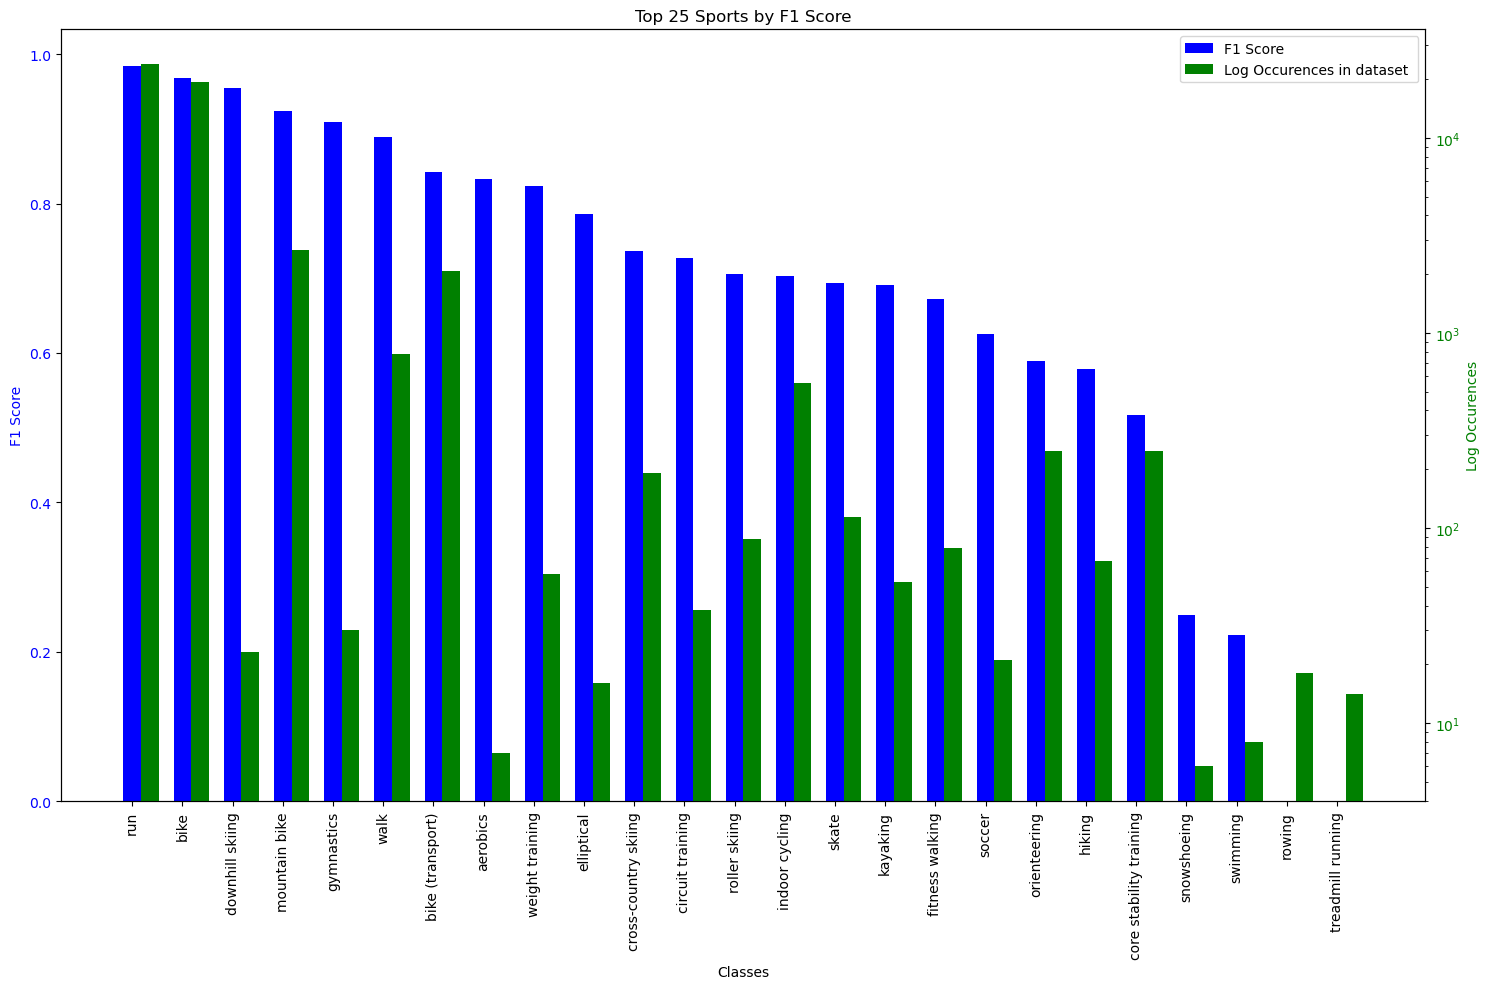

<Figure size 640x480 with 0 Axes>

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



# Generate classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# We are interested in f1-score and support, and we remove the last few rows which are average/total values
report_df = report_df[:-3]

# Sort by F1-score and select top 30
top_30 = report_df.sort_values(by='f1-score', ascending=False).head(27)

# Creating a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(15, 10))

# Bar width
bar_width = 0.35

# Index for each class/label
index = range(len(top_30))

# Plotting F1 score
f1_bars = ax1.bar(index, top_30['f1-score'], bar_width, color='b', label='F1 Score')
ax1.set_xlabel('Classes')
ax1.set_ylabel('F1 Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(index)
ax1.set_xticklabels(top_30.index, rotation=90)

# Create a second y-axis for support, set to log scale
ax2 = ax1.twinx()
support_bars = ax2.bar([i + bar_width for i in index], top_30['support'], bar_width, color='g', label='Support')
ax2.set_ylabel('Log Occurences', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_yscale('log')  # Set y-axis to log scale

# Title and legend
plt.title('Top 25 Sports by F1 Score')
ax1.legend(handles=[f1_bars, support_bars], labels=['F1 Score', 'Log Occurences in dataset '], loc='upper right')
fig.tight_layout()
plt.show()
plt.savefig('../figures/no_resample_results.png')

## RF with synthethic minority oversampling from imblearn and random undersampling

In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Create the SMOTE object for over-sampling
smote = SMOTE(random_state=42)



# Define a pipeline for applying over-sampling followed by under-sampling
resample_pipeline = Pipeline([('SMOTE', smote), ('UnderSampler', under_sampler)])

# Resample the training data using the pipeline
X_train_resampled, y_train_resampled = resample_pipeline.fit_resample(X_train, y_train)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Train the model on the resampled training set
rf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the original (un-resampled) test set
y_pred = rf.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
                          precision    recall  f1-score   support

               aerobics       0.71      0.71      0.71         7
                   bike       0.98      0.96      0.97     19395
       bike (transport)       0.86      0.87      0.86      2085
       circuit training       0.83      0.76      0.79        38
core stability training       0.63      0.71      0.67       248
   cross-country skiing       0.80      0.87      0.83       191
        downhill skiing       0.91      0.91      0.91        23
             elliptical       0.75      0.75      0.75        16
        fitness walking       0.87      0.76      0.81        79
             gymnastics       0.93      0.87      0.90        30
                 hiking       0.58      0.74      0.65        68
         indoor cycling       0.70      0.85      0.77       552
               kayaking       0.79      0.83      0.81        53
          mountain bike       0.90      0.95      0.93      2667


## much better macro recall slightly worse macro precision overall much better at predicting minority classes, slightly better total accuracy

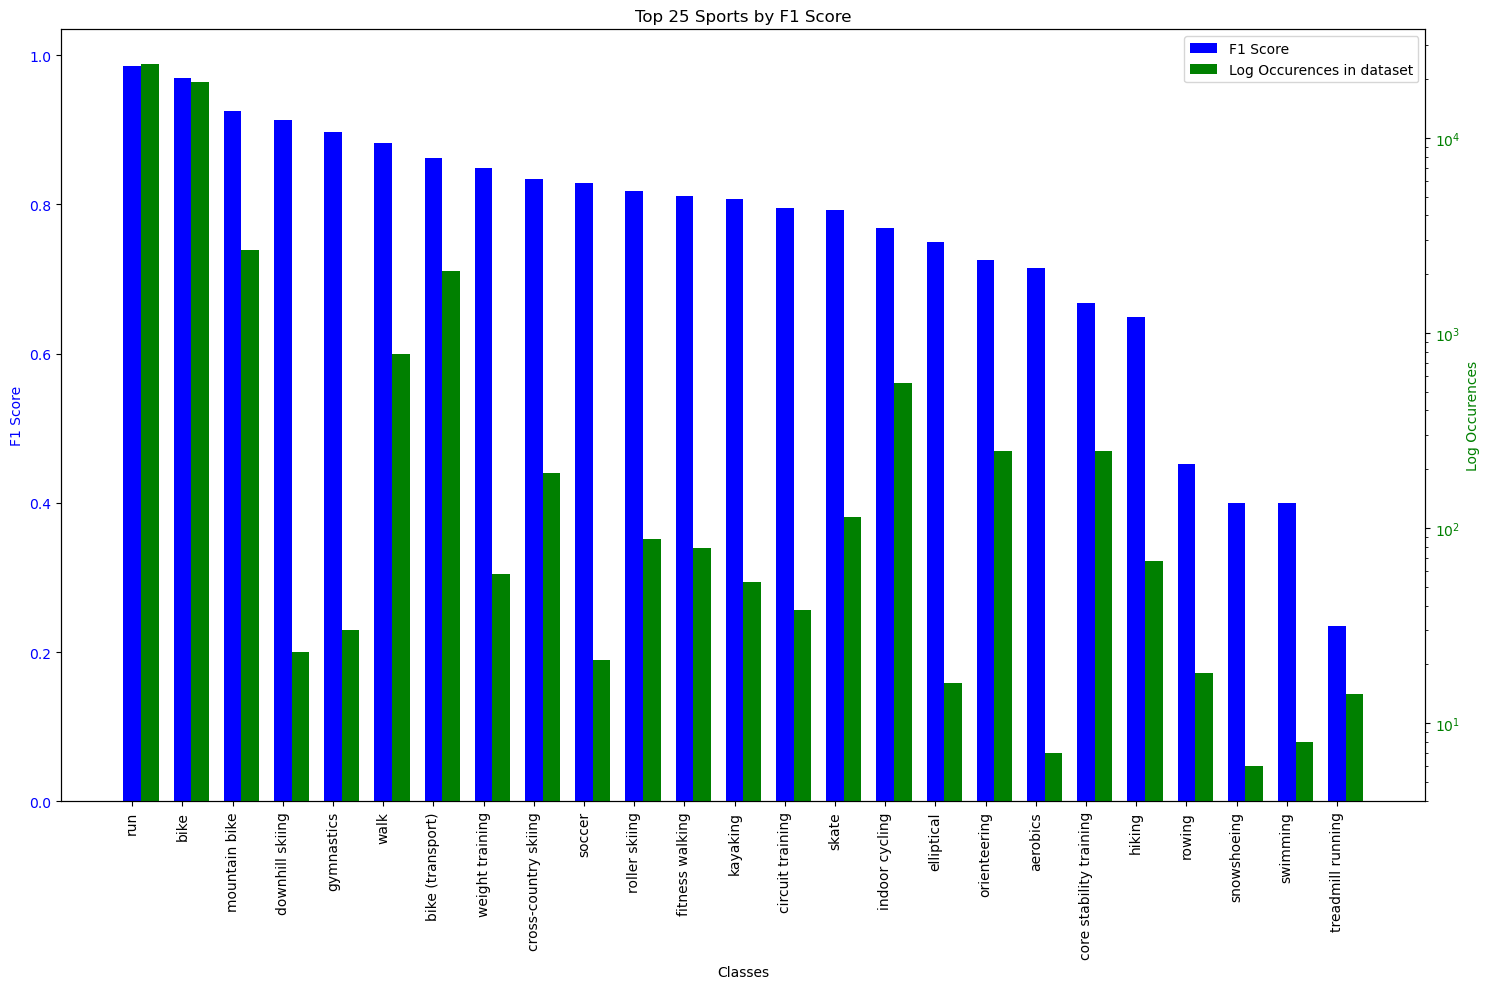

In [13]:

# Generate classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# We are interested in f1-score and support, and we remove the last few rows which are average/total values
report_df = report_df[:-3]

# Sort by F1-score and select top 30
top_30 = report_df.sort_values(by='f1-score', ascending=False).head(27)

# Creating a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(15, 10))

# Bar width
bar_width = 0.35

# Index for each class/label
index = range(len(top_30))

# Plotting F1 score
f1_bars = ax1.bar(index, top_30['f1-score'], bar_width, color='b', label='F1 Score')
ax1.set_xlabel('Classes')
ax1.set_ylabel('F1 Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(index)
ax1.set_xticklabels(top_30.index, rotation=90)

# Create a second y-axis for support, set to log scale
ax2 = ax1.twinx()
support_bars = ax2.bar([i + bar_width for i in index], top_30['support'], bar_width, color='g', label='Support')
ax2.set_ylabel('Log Occurences', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_yscale('log')  # Set y-axis to log scale

# Title and legend
plt.title('Top 25 Sports by F1 Score')
ax1.legend(handles=[f1_bars, support_bars], labels=['F1 Score', 'Log Occurences in dataset'], loc='upper right')
fig.tight_layout()
plt.show()
plt.savefig('../figures/resampled_results.png')

## cross val and hyperparam tuning

In [11]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30],  # Maximum depth of the tree
       
}

# Initialize the GridSearchCV with a RandomForestClassifier and the parameter grid
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
    param_grid=param_grid,
    cv=3,           # Number of folds in cross-validation
    verbose=2,      # Controls the verbosity: the higher, the more messages
    n_jobs=-1       # Number of jobs to run in parallel
)

# Fit the GridSearchCV to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Retrieve the best hyperparameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best estimator to make predictions
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# Evaluate the model with the best parameters
print("Classification Report with Best Parameters:\n", classification_report(y_test, y_pred_best))
print("Accuracy with Best Parameters:", accuracy_score(y_test, y_pred_best))


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .....................max_depth=10, n_estimators=100; total time= 8.2min
[CV] END .....................max_depth=10, n_estimators=100; total time= 8.5min
[CV] END .....................max_depth=10, n_estimators=100; total time= 8.6min
[CV] END .....................max_depth=20, n_estimators=100; total time=14.4min
[CV] END .....................max_depth=20, n_estimators=100; total time=14.7min
[CV] END .....................max_depth=20, n_estimators=100; total time=14.9min
[CV] END .....................max_depth=10, n_estimators=200; total time=15.5min
[CV] END .....................max_depth=10, n_estimators=200; total time=15.6min
[CV] END .....................max_depth=10, n_estimators=200; total time=16.3min
[CV] END .....................max_depth=30, n_estimators=100; total time=15.7min
[CV] END .....................max_depth=30, n_estimators=100; total time=15.7min
[CV] END .....................max_depth=30, n_est

# increasing params to higher numbers doesnt improve performance